# Multimodal Cyclic Translation Network (MCTN) Model - MOSEI

In [4]:
import gdown

file_id = "1zFOBHijVppTiyteSsi0aTFYPEsda_AOk"
destination = "mosei_raw.pkl" 

gdown.download(
    f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1zFOBHijVppTiyteSsi0aTFYPEsda_AOk
From (redirected): https://drive.google.com/uc?id=1zFOBHijVppTiyteSsi0aTFYPEsda_AOk&confirm=t&uuid=c35fcadf-74e5-4a50-9edf-0694d7e2c6b7
To: /workspace/rongchuan/ipynb/Multimodal-Emotion-Recognition/src/mosei_raw.pkl
100%|██████████| 9.94G/9.94G [01:21<00:00, 122MB/s] 


'mosei_raw.pkl'

## Importing Libraries

In [1]:
import sys
import torch
from torch import nn
import matplotlib.pyplot as plt

sys.path.append('/content/Multimodal-Emotion-Recognition/src')

## Importing Helper Functions

In [2]:
from loader import get_dataloader
from unimodals.modules import MLP
from fusions.MCTN import Encoder, Decoder
from evaluation.complexity import all_in_one
from training.MCTN import train, test
from utils import get_default_device, save_results

## Loading the Dataset

In [3]:
train_data, valid_data, test_data = get_dataloader('mosei_senti_data.pkl')

In [4]:
device = get_default_device()
print(device)

cuda


## Model Architecture

In [5]:
max_seq = 20
feature_dim = 300
hidden_dim = 32

encoder0 = Encoder(feature_dim, hidden_dim, n_layers=1, dropout=0.0).to(device)
decoder0 = Decoder(hidden_dim, feature_dim, n_layers=1, dropout=0.0).to(device)
encoder1 = Encoder(hidden_dim, hidden_dim, n_layers=1, dropout=0.0).to(device)
decoder1 = Decoder(hidden_dim, feature_dim, n_layers=1, dropout=0.0).to(device)

reg_encoder = nn.GRU(hidden_dim, 32).to(device)
head = MLP(32, 64, 1).to(device)

allmodules = [encoder0, decoder0, encoder1, decoder1, reg_encoder, head]

## Training

In [6]:
OUTPUT_MODEL_FILE_NAME = 'mosei_raw_Multimodal_Cyclic_Translation_Network'

In [7]:
def trainprocess():
    global OUTPUT_MODEL_FILE_NAME

    train_losses, valid_losses = train(
        train_data,
        valid_data,
        encoder0,
        decoder0,
        encoder1,
        decoder1,
        reg_encoder,
        head,
        criterion_t0=nn.MSELoss(),
        criterion_c=nn.MSELoss(),
        criterion_t1=nn.MSELoss(),
        criterion_r=nn.L1Loss(),
        max_seq_len=20,
        mu_t0=0.01,
        mu_c=0.01,
        mu_t1=0.01,
        dropout_p=0.15,
        early_stop=False,
        patience_num=15,
        lr=1e-4,
        weight_decay=0.01,
        op_type=torch.optim.AdamW,
        epoch=200,
        model_save=f"content/{OUTPUT_MODEL_FILE_NAME}.pt",
    )
    return train_losses, valid_losses

train_losses, valid_losses = all_in_one(trainprocess, allmodules)

Epoch [1/200]
Train Loss: 2.8838 | Regression Loss: 0.8446 | Embedding Loss: 2.0392
Valid MAE: 0.7924 | Valid Accuracy: 50.1873% | Valid Recall: 35.1671%
Saving Best

Epoch [2/200]
Train Loss: 2.8587 | Regression Loss: 0.8306 | Embedding Loss: 2.0281
Valid MAE: 0.7856 | Valid Accuracy: 55.4307% | Valid Recall: 44.9861%
Saving Best

Epoch [3/200]
Train Loss: 2.8311 | Regression Loss: 0.8052 | Embedding Loss: 2.0259
Valid MAE: 0.7705 | Valid Accuracy: 64.7940% | Valid Recall: 71.1699%
Saving Best

Epoch [4/200]
Train Loss: 2.8083 | Regression Loss: 0.7824 | Embedding Loss: 2.0258
Valid MAE: 0.7707 | Valid Accuracy: 66.5062% | Valid Recall: 65.4596%

Epoch [5/200]
Train Loss: 2.7965 | Regression Loss: 0.7717 | Embedding Loss: 2.0248
Valid MAE: 0.7747 | Valid Accuracy: 65.1685% | Valid Recall: 61.2117%

Epoch [6/200]
Train Loss: 2.7833 | Regression Loss: 0.7585 | Embedding Loss: 2.0248
Valid MAE: 0.7799 | Valid Accuracy: 62.7608% | Valid Recall: 55.4318%

Epoch [7/200]
Train Loss: 2.7729 |

Text(0.5, 1.0, 'Loss vs. No. of epochs')

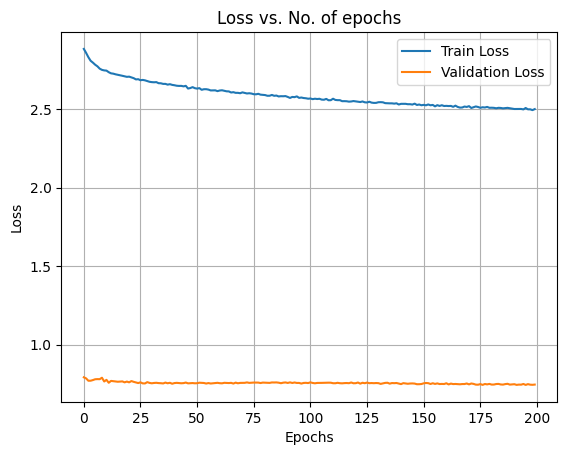

In [8]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [10]:
save_results(train_losses, valid_losses, f'content/{OUTPUT_MODEL_FILE_NAME}.pkl')

## Testing

In [12]:
model = torch.load(f'content/{OUTPUT_MODEL_FILE_NAME}.pt').to(device)

test(model, test_data)

/tmp/ipykernel_620645/2986021083.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f'content/{OUTPUT_MODEL_FILE_NAME}.pt').to(device)


Test MAE: 0.8002 | Test Accuracy: 59.4874% | Test Recall: 74.0608%
Inference Time: 2s332ms
Inference Params: 198809
